In [1]:
import time

In [2]:
start_time = time.time()

In [3]:
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import lmfit
import json
import astropy.units as u
import bfunc
import pandas as pd
import corner
from scipy import interpolate
import pickle
import bplot

Data load and region parameters

In [4]:
data = "N595"

In [5]:
name = "NGC 595"

In [6]:
pickle_in = open("Results//SF" + data + ".pkl", "rb")
SFresults = pickle.load(pickle_in)

In [7]:
mask = SFresults["SF"]["N pairs"] > 0

In [8]:
B = SFresults["b2"][mask]
r = SFresults["s"][mask]
pc = SFresults["pc"]
pix = SFresults["pix"]
box_size = SFresults["box_size"]
pc_per_arcsec = pc

# Merge first K points
K = 1
r[K] = np.mean(r[:K])
B[K] = np.mean(B[:K])
r = r[K:]
B = B[K:]

In [9]:
model = lmfit.Model(bfunc.bfunc03s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [10]:
# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2.0 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2.0 * B.max())

# m between 1/2 and 5/3
model.set_param_hint("m", value=1.0, min=0.5, max=2.0)

# Seeing RMS between 0.1 and 1.5 arcsec
model.set_param_hint(
    "s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec
)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
# model.set_param_hint("box_size", value=box_size, vary=False)



In [11]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise
value,19.627578,52.229178,1.0,2.036217,1.306027
min,1.962758,26.114589,0.5,0.407243,0.000000
max,392.551565,208.916711,2.0,6.108652,7.836159


In [12]:
relative_uncertainty = 0.055
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.275 * box_size
weights[large_scale] /= 3.0
weights[:3] /= 4.5

In [13]:
to_fit = r <= 0.5 * box_size
#to_fit = ~large_scale
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [14]:
to_fit

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False])

In [15]:
result

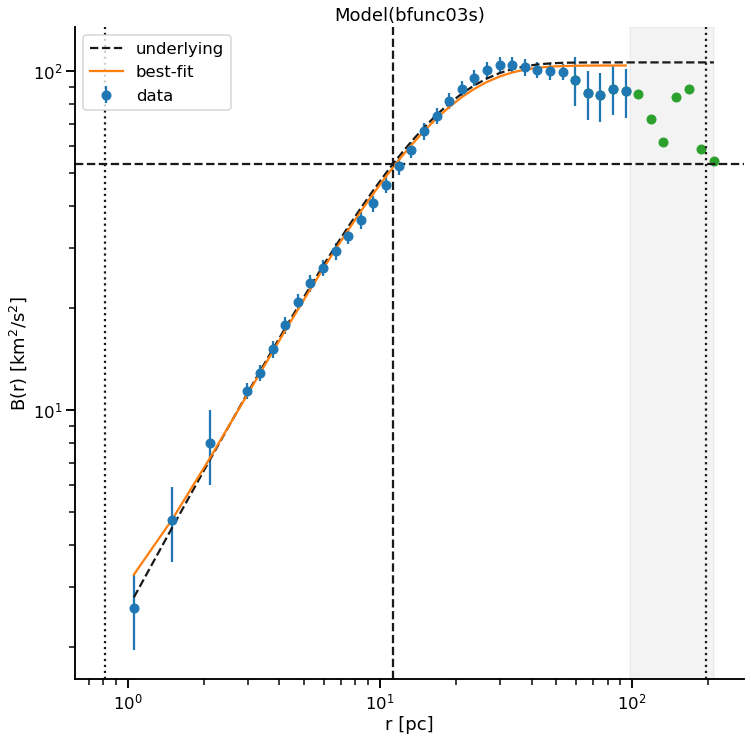

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(
    r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value
)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(box_size, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(box_size / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale="log",
    yscale="log",
    xlabel="r [pc]",
    ylabel=r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine()

emcee

In [17]:
emcee_kws = dict(
    steps=50000, burn=500, thin=50, is_weighted=True, progress=False, workers=16
)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [18]:
result_emcee = model.fit(
    data=B[to_fit],
    r=r[to_fit],
    weights=weights[to_fit],
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [19]:
result_emcee

In [20]:
#quantiles = np.percentile(result_emcee.flatchain['s0'], [2.28, 15.9, 50, 84.2, 97.7])
#print(f"\n\n1 sigma spread = {0.5 * (quantiles[3] - quantiles[1]):.3f}")
#print(f"2 sigma spread = {0.5 * (quantiles[4] - quantiles[0]):.3f}")

In [21]:
result_emcee.flatchain['s0']

0        0.815669
1        0.422818
2        0.652778
3        0.721298
4        0.505694
           ...   
98995    0.922912
98996    0.547668
98997    0.408142
98998    0.764560
98999    0.524522
Name: s0, Length: 99000, dtype: float64

In [22]:
s2=np.percentile(result_emcee.flatchain['s0'],[2.5, 97.5])

In [23]:
result_emcee.params['s0'].value-s2[0],result_emcee.params['s0'].value,s2[1]-result_emcee.params['s0'].value

(0.1292501392509358, 0.5417075022408167, 0.48292099243022113)

In [24]:
result_emcee.params['s0'].value-s2[0]

0.1292501392509358

In [25]:
s2[1]-result_emcee.params['s0'].value

0.48292099243022113

Text(0, 0.5, 'acceptance fraction')

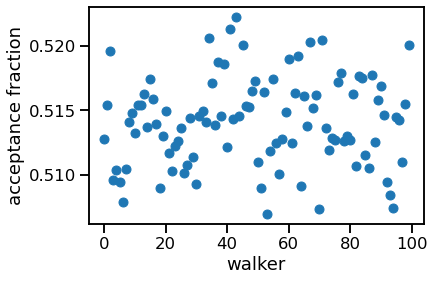

In [26]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")

In [27]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f"{p} = {result_emcee.acor[i]:.3f}")
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 65.284
sig2 = 68.949
m = 66.866
s0 = 80.118
noise = 68.234


In [28]:
#emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
#                             truths=list(result_emcee.params.valuesdict().values()))

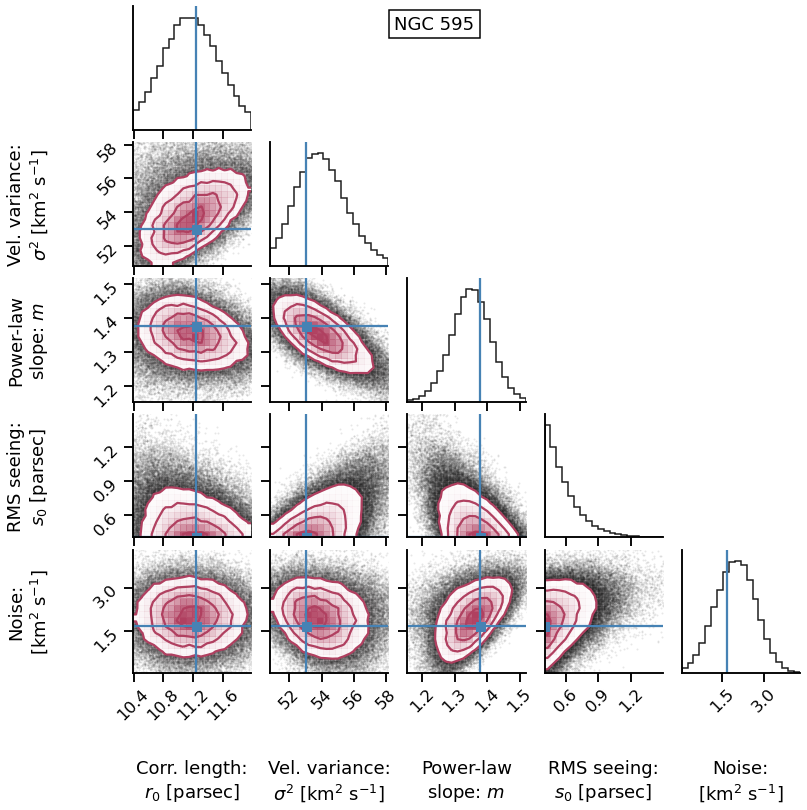

In [29]:
bplot.corner_plot(
    result_emcee, result, name, data, data_ranges=[0.95, 0.97, 0.995, 0.997, 0.999]
)

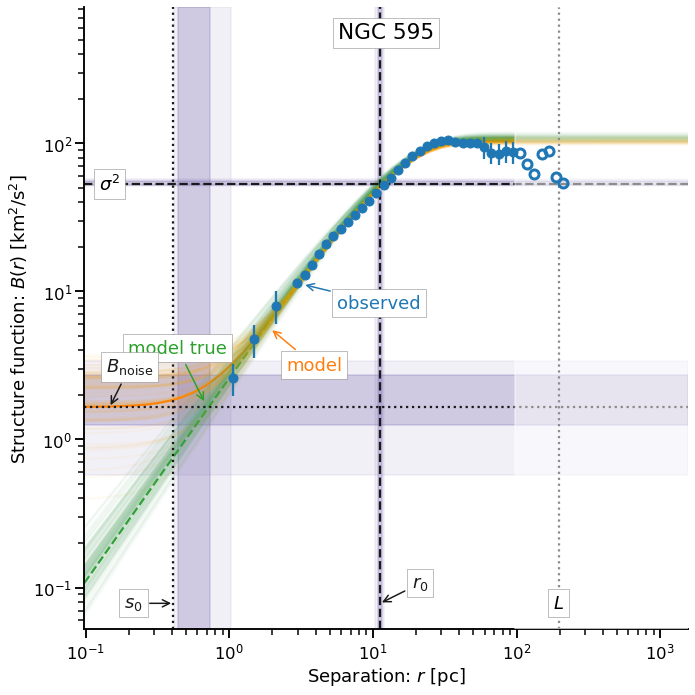

In [30]:
bplot.strucfunc_plot(
    result_emcee, result, r, B, to_fit, name, data, box_size, large_scale
)

In [31]:
#bplot.strucfunc_plot(
#    result_emcee, result_emcee, r, B, to_fit, name, data, box_size, large_scale
#)

In [32]:
CIresults = {
    "result_emcee": result_emcee,
    "result": result,
    "r": r,
    "B": B,
    "to_fit": to_fit,
    "name": name,
    "data": data,
    "box_size": box_size,
    "large_scale": large_scale,
}

In [33]:
f = open("Results//CI" + data + ".pkl", "wb")
pickle.dump(CIresults, f)
f.close()

In [34]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 371.6676812171936 seconds ---
